In [1]:
# Imports
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

import numpy as np
from pandas import read_csv, DataFrame
from keras import models, layers, initializers
from keras.wrappers.scikit_learn import KerasClassifier
import keras.metrics as km
import keras.backend as kb
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, PredefinedSplit

import preprocess as p

In [5]:
# Classification metrics
METRICS = [
      km.TruePositives(name='tp'),
      km.FalsePositives(name='fp'),
      km.TrueNegatives(name='tn'),
      km.FalseNegatives(name='fn'), 
      km.BinaryAccuracy(name='accuracy'),
      km.Precision(name='precision'),
      km.Recall(name='recall'),
      km.AUC(name='auc')]


# Visualises results of a grid search
def plot_gs_results(grid_result, ignore = [None]):
    if dim == 1:
        pass
    elif dim == 2:
        pass
    
    
    

# Load Training Data

In [6]:
# Load data
train_pred = read_csv("../data/is_wkt_train_preds.csv")
train_out = read_csv("../data/is_wkt_train_labs.csv")

# Preprocess
train_x, means, sds = p.standardise(p.split_new_ball(train_pred.to_numpy()))
train_y = (train_out.to_numpy())[:,1]

# Validation set
val_prop = int(np.ceil(train_x.shape[0]/10))
x_val = train_x[:val_prop]
partial_x_train = train_x[val_prop:]
y_val = train_y[:val_prop]
partial_y_train = train_y[val_prop:]

# Split indicator
split_index = [-1 if x > val_prop else 0 for x in range(train_x.shape[0])]
pds = PredefinedSplit(test_fold = split_index)

INPUT_DIM = train_x.shape[1]

# Epochs & Batch Size

## Model Wrapper

In [7]:
def build_model():
       
    model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(INPUT_DIM,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=METRICS)

    return model

model = KerasClassifier(build_fn=build_model, verbose = 0)

# Scaled initial weights
neg, pos = np.bincount(train_y)
total = neg + pos
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

## Grid Searches

In [6]:
# epochs, batch_size search 1
param_grid = dict(batch_size = [16,64,128,512,1024,4096,8192],
                  epochs = [10,50,100,200])

# Guard to prevent this code from being run accidentially - it takes a rather long time

if False:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=pds, refit=False)
    grid_result = grid.fit(train_x, train_y, class_weight = class_weight)

In [8]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.801259 using {'batch_size': 512, 'epochs': 100}
0.673224 (0.000000) with: {'batch_size': 16, 'epochs': 10}
0.731364 (0.000000) with: {'batch_size': 16, 'epochs': 50}
0.363927 (0.000000) with: {'batch_size': 16, 'epochs': 100}
0.448231 (0.000000) with: {'batch_size': 16, 'epochs': 200}
0.238195 (0.000000) with: {'batch_size': 64, 'epochs': 10}
0.478080 (0.000000) with: {'batch_size': 64, 'epochs': 50}
0.592495 (0.000000) with: {'batch_size': 64, 'epochs': 100}
0.414106 (0.000000) with: {'batch_size': 64, 'epochs': 200}
0.541110 (0.000000) with: {'batch_size': 128, 'epochs': 10}
0.462508 (0.000000) with: {'batch_size': 128, 'epochs': 50}
0.645964 (0.000000) with: {'batch_size': 128, 'epochs': 100}
0.677106 (0.000000) with: {'batch_size': 128, 'epochs': 200}
0.589447 (0.000000) with: {'batch_size': 512, 'epochs': 10}
0.550606 (0.000000) with: {'batch_size': 512, 'epochs': 50}
0.801259 (0.000000) with: {'batch_size': 512, 'epochs': 100}
0.657236 (0.000000) with: {'batch_size': 512,

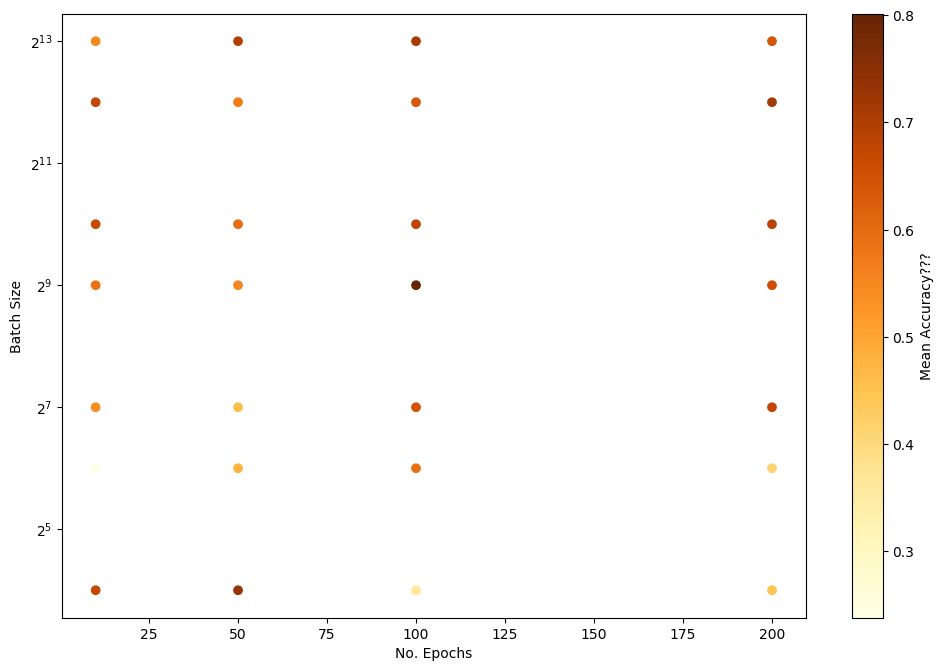

In [28]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
gs_res = grid_result.cv_results_
plt.scatter(x = gs_res['param_epochs'], y = gs_res['param_batch_size'], c=gs_res['mean_test_score'], cmap=plt.get_cmap('YlOrBr'))
plt.xlabel('No. Epochs')
plt.ylabel('Batch Size')
plt.yscale("log", basey = 2)
cb = plt.colorbar()
cb.set_label("Mean Accuracy???")
#plt.gray()
plt.show()

In [8]:
# Optimal values
NO_EPOCHS = 100;
BATCH_SIZE = 512;

In [12]:
# Fit 'optimal so far' model
history = model.fit(train_x, train_y, epochs = NO_EPOCHS, batch_size = BATCH_SIZE, validation_data=(x_val, y_val), class_weight=class_weight, verbose = 1)

Epoch 1/100
891/891 [==============================] - 2s 2ms/step - loss: 0.6770 - tp: 4515.0000 - fp: 190600.0000 - tn: 302798.0000 - fn: 3638.0000 - accuracy: 0.6127 - precision: 0.0231 - recall: 0.5538 - auc: 0.6179 - val_loss: 0.6897 - val_tp: 484.0000 - val_fp: 19568.0000 - val_tn: 25267.0000 - val_fn: 277.0000 - val_accuracy: 0.5648 - val_precision: 0.0241 - val_recall: 0.6360 - val_auc: 0.6568
Epoch 2/100
891/891 [==============================] - 1s 2ms/step - loss: 0.6612 - tp: 4369.0000 - fp: 172191.0000 - tn: 276372.0000 - fn: 3023.0000 - accuracy: 0.6157 - precision: 0.0247 - recall: 0.5910 - auc: 0.6457 - val_loss: 0.6488 - val_tp: 440.0000 - val_fp: 16229.0000 - val_tn: 28606.0000 - val_fn: 321.0000 - val_accuracy: 0.6370 - val_precision: 0.0264 - val_recall: 0.5782 - val_auc: 0.6581
Epoch 3/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6585 - tp: 4437.0000 - fp: 170025.0000 - tn: 278538.0000 - fn: 2955.0000 - accuracy: 0.6206 - precision: 0.0254 -

891/891 [==============================] - 1s 1ms/step - loss: 0.6482 - tp: 4307.0000 - fp: 149875.0000 - tn: 298688.0000 - fn: 3085.0000 - accuracy: 0.6645 - precision: 0.0279 - recall: 0.5827 - auc: 0.6720 - val_loss: 0.6367 - val_tp: 441.0000 - val_fp: 14859.0000 - val_tn: 29976.0000 - val_fn: 320.0000 - val_accuracy: 0.6671 - val_precision: 0.0288 - val_recall: 0.5795 - val_auc: 0.6838
Epoch 22/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6473 - tp: 4375.0000 - fp: 150484.0000 - tn: 298079.0000 - fn: 3017.0000 - accuracy: 0.6633 - precision: 0.0283 - recall: 0.5919 - auc: 0.6728 - val_loss: 0.5960 - val_tp: 410.0000 - val_fp: 12590.0000 - val_tn: 32245.0000 - val_fn: 351.0000 - val_accuracy: 0.7162 - val_precision: 0.0315 - val_recall: 0.5388 - val_auc: 0.6826
Epoch 23/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6477 - tp: 4394.0000 - fp: 151210.0000 - tn: 297353.0000 - fn: 2998.0000 - accuracy: 0.6618 - precision: 0.0282 - recall: 0

891/891 [==============================] - 1s 1ms/step - loss: 0.6477 - tp: 4318.0000 - fp: 146830.0000 - tn: 301733.0000 - fn: 3074.0000 - accuracy: 0.6712 - precision: 0.0286 - recall: 0.5841 - auc: 0.6742 - val_loss: 0.7343 - val_tp: 552.0000 - val_fp: 20074.0000 - val_tn: 24761.0000 - val_fn: 209.0000 - val_accuracy: 0.5552 - val_precision: 0.0268 - val_recall: 0.7254 - val_auc: 0.6949
Epoch 42/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6473 - tp: 4350.0000 - fp: 147360.0000 - tn: 301203.0000 - fn: 3042.0000 - accuracy: 0.6701 - precision: 0.0287 - recall: 0.5885 - auc: 0.6742 - val_loss: 0.6429 - val_tp: 465.0000 - val_fp: 14713.0000 - val_tn: 30122.0000 - val_fn: 296.0000 - val_accuracy: 0.6708 - val_precision: 0.0306 - val_recall: 0.6110 - val_auc: 0.6962
Epoch 43/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6474 - tp: 4377.0000 - fp: 148326.0000 - tn: 300237.0000 - fn: 3015.0000 - accuracy: 0.6681 - precision: 0.0287 - recall: 0

891/891 [==============================] - 1s 1ms/step - loss: 0.6456 - tp: 4131.0000 - fp: 135040.0000 - tn: 313523.0000 - fn: 3261.0000 - accuracy: 0.6967 - precision: 0.0297 - recall: 0.5588 - auc: 0.6754 - val_loss: 0.5957 - val_tp: 416.0000 - val_fp: 10952.0000 - val_tn: 33883.0000 - val_fn: 345.0000 - val_accuracy: 0.7522 - val_precision: 0.0366 - val_recall: 0.5466 - val_auc: 0.6953
Epoch 62/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6471 - tp: 4108.0000 - fp: 134178.0000 - tn: 314385.0000 - fn: 3284.0000 - accuracy: 0.6985 - precision: 0.0297 - recall: 0.5557 - auc: 0.6734 - val_loss: 0.6247 - val_tp: 444.0000 - val_fp: 12726.0000 - val_tn: 32109.0000 - val_fn: 317.0000 - val_accuracy: 0.7139 - val_precision: 0.0337 - val_recall: 0.5834 - val_auc: 0.6909
Epoch 63/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6466 - tp: 4122.0000 - fp: 134569.0000 - tn: 313994.0000 - fn: 3270.0000 - accuracy: 0.6977 - precision: 0.0297 - recall: 0

891/891 [==============================] - 1s 1ms/step - loss: 0.6519 - tp: 4077.0000 - fp: 141299.0000 - tn: 307264.0000 - fn: 3315.0000 - accuracy: 0.6828 - precision: 0.0280 - recall: 0.5515 - auc: 0.6651 - val_loss: 0.7155 - val_tp: 483.0000 - val_fp: 18730.0000 - val_tn: 26105.0000 - val_fn: 278.0000 - val_accuracy: 0.5831 - val_precision: 0.0251 - val_recall: 0.6347 - val_auc: 0.6591
Epoch 82/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6536 - tp: 4087.0000 - fp: 143333.0000 - tn: 305230.0000 - fn: 3305.0000 - accuracy: 0.6784 - precision: 0.0277 - recall: 0.5529 - auc: 0.6636 - val_loss: 0.6456 - val_tp: 451.0000 - val_fp: 14774.0000 - val_tn: 30061.0000 - val_fn: 310.0000 - val_accuracy: 0.6692 - val_precision: 0.0296 - val_recall: 0.5926 - val_auc: 0.6797
Epoch 83/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6529 - tp: 4246.0000 - fp: 150343.0000 - tn: 298220.0000 - fn: 3146.0000 - accuracy: 0.6634 - precision: 0.0275 - recall: 0